# In this notebook

I run the SwAV model on the validation set to confirm the results of the paper.

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets, transforms

from sklearn.model_selection import train_test_split

In [78]:
# Import the model and remove the last 2 layers
model = torch.hub.load('facebookresearch/swav:main', 'resnet50')
model.fc = nn.Identity()
# model.avgpool = nn.Identity()

Using cache found in /home/zdc6/.cache/torch/hub/facebookresearch_swav_main


In [94]:
# A special class is required to work with this data, since the data is not
# organized by label already. All this does is tell the data loader how to pull the 
# data and labels
#
# See documentation here: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html 

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

class CustomImageDataset(datasets.VisionDataset):
	def __init__(
		self,
		parent_dir,
		files,
		labels,
		label_index,
		transform=None
		):

		self.labels = labels
		self.transform = transform
		self.img_files = files
		self.label_index = label_index
		self.img_dir = parent_dir

	def __len__(self):
		return len(self.img_files)

	def __getitem__(self, idx):
		"""
		This function pulls the data from the image directory, looks up the
		data, and returns the photo, along with the label associated with
		the image.
		"""

		# Get the image at index __
		img_path = os.path.join(self.img_dir, self.img_files[idx])
		file_name = self.img_files[idx]
		image = pil_loader(img_path)
		# image = Image.open(img_path)

		if self.transform:
			image = self.transform(image)

		label = self.labels[idx]

		# Return the image and the label
		return image, torch.tensor(self.label_index.get(label))

In [95]:
# Generate the dataset from only the validation data
data_dir = '../data/ImageNet/ILSVRC/Data/CLS-LOC/val'
data_files = os.listdir(data_dir)
# This file provides the mapping from the file name to the class label.
labels_file = '../data/ImageNet/LOC_val_solution.csv'
label_map = {key: value.split(" ")[0] for key, value in pd.read_csv(labels_file).to_numpy()}
labels = [label_map[image_id[0:-5]] for image_id in data_files]
label_index = {key: idx for idx, key in enumerate(list(set(labels)))}

train_files, val_files, train_labels, val_labels = train_test_split(data_files, labels, test_size=0.2, stratify=labels)

train_dataset = CustomImageDataset(
	data_dir,
	train_files,
	train_labels,
	label_index,
	transforms.Compose([
        transforms.RandomResizedCrop(224),	
		transforms.RandomHorizontalFlip(),
		transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
)

val_dataset = CustomImageDataset(
	data_dir,
	val_files,
	val_labels,
	label_index,
	transforms.Compose([
		transforms.Resize(256),
		transforms.CenterCrop(224),
		transforms.ToTensor(),
		transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
		
	])
)

In [96]:
batch_size=32
# Set up train and val loaders for the data
train_loader = torch.utils.data.DataLoader(
	train_dataset,
	batch_size=batch_size
)
val_loader = torch.utils.data.DataLoader(
	val_dataset,
	batch_size=batch_size
)

In [97]:
# Set up the part of the model that is going to be changed.
# Code copied from here: https://github.com/facebookresearch/swav/blob/main/eval_linear.py
class RegLog(nn.Module):
    """Creates logistic regression on top of frozen features"""

    def __init__(self, num_labels, arch="resnet50", global_avg=False, use_bn=True):
        super(RegLog, self).__init__()
        self.bn = None
        if global_avg:
            if arch == "resnet50":
                s = 2048
            elif arch == "resnet50w2":
                s = 4096
            elif arch == "resnet50w4":
                s = 8192
            # self.av_pool = nn.AdaptiveAvgPool2d((1, 1))
        else:
            assert arch == "resnet50"
            s = 8192
            self.av_pool = nn.AvgPool2d(6, stride=1)
            if use_bn:
                self.bn = nn.BatchNorm2d(2048)
        self.linear = nn.Linear(s, num_labels)
        self.linear.weight.data.normal_(mean=0.0, std=0.01)
        self.linear.bias.data.zero_()

    def forward(self, x):
        # average pool the final feature map
        # x = self.av_pool(x)

        # optional BN
        if self.bn is not None:
            x = self.bn(x)

        # flatten
        x = x.view(x.size(0), -1)

        # linear layer
        return self.linear(x)


linear_classifier = RegLog(1000, "resnet50", True, False)

In [99]:
# Set up the training parameters
optimizer = torch.optim.SGD(
	linear_classifier.parameters(),
	lr=0.01,
	nesterov=False,
	momentum=0.9,
	weight_decay=1e-6
)
num_epochs=10

In [110]:
# For capturing accuracy
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [100]:
model = model.to('cuda')
linear_classifier = linear_classifier.to('cuda')

# Set up where we want to stor data
training_loss = []
val_loss = []

top_1_acc = []
top_5_acc = []

In [125]:
# I manually edited the learning rate when the model seemed like
# it was jumping around so that it would land on a single value.
optimizer.lr = 0.001

In [126]:
for epoch in range(num_epochs):
	train_loss = 0
	# Train
	model.eval()
	linear_classifier.train()
	criterion = nn.CrossEntropyLoss().cuda()

	for iter_epoch, (inp, target) in enumerate(train_loader):
		batch_loss = 0
		# move to gpu
		inp = inp.to('cuda')
		target = target.to('cuda')# cuda(non_blocking=True)

		with torch.no_grad():
			output = model(inp)

		output = linear_classifier(output)

		# Calculate the loss and update the parameters
		loss = criterion(output, target)
		train_loss += loss.item() / inp.size(0)
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		# Print the batch loss
		if iter_epoch % 200 == 0:
			print(f"Batch {iter_epoch} train loss: {loss.item() / inp.size(0):.2f}")

	avg_loss = train_loss/iter_epoch
	print(f"Epoch {epoch} training loss: {avg_loss:.2f}")
	training_loss.append(avg_loss)
	# Validation
	test_loss = 0
	model.eval()
	linear_classifier.eval()

	criterion = nn.CrossEntropyLoss().cuda()

	top_1 = []
	top_5 = []
	with torch.no_grad():
		for iter_epoch, (inp, target) in enumerate(val_loader):
			# move to gpu
			inp = inp.cuda(non_blocking=True)
			target = target.cuda(non_blocking=True)

			# compute output
			output = linear_classifier(model(inp))
			loss = criterion(output, target)
			test_loss += loss.item() / inp.size(0)
			acc1, acc5 = accuracy(output, target, topk=(1,5))
			top_1.append(acc1.item())
			top_5.append(acc5.item())
			if iter_epoch % 200 == 0: 
				print(f"Batch {iter_epoch} val loss: {loss.item():.2f}")
	avg_loss = test_loss / iter_epoch
	print(f"Epoch {epoch} test loss: {avg_loss:.2f}")
	val_loss.append(avg_loss)

	# Record top-1 accuracy
	top_1_acc.append(np.mean(top_1))
	top_5_acc.append(np.mean(top_5))


Batch 0 train loss: 0.09
Batch 200 train loss: 0.08
Batch 400 train loss: 0.09
Batch 600 train loss: 0.08
Batch 800 train loss: 0.08
Batch 1000 train loss: 0.08
Batch 1200 train loss: 0.07
Epoch 0 training loss: 0.08
Batch 0 val loss: 2.90
Batch 200 val loss: 2.18
Epoch 0 test loss: 0.08
Batch 0 train loss: 0.08
Batch 200 train loss: 0.08
Batch 400 train loss: 0.08
Batch 600 train loss: 0.07
Batch 800 train loss: 0.08
Batch 1000 train loss: 0.08
Batch 1200 train loss: 0.07
Epoch 1 training loss: 0.08
Batch 0 val loss: 2.82
Batch 200 val loss: 2.09
Epoch 1 test loss: 0.08
Batch 0 train loss: 0.09
Batch 200 train loss: 0.08
Batch 400 train loss: 0.08
Batch 600 train loss: 0.07
Batch 800 train loss: 0.08
Batch 1000 train loss: 0.07
Batch 1200 train loss: 0.07
Epoch 2 training loss: 0.08
Batch 0 val loss: 2.75
Batch 200 val loss: 1.99
Epoch 2 test loss: 0.07
Batch 0 train loss: 0.08


KeyboardInterrupt: 

Text(0, 0.5, 'Cross entropy loss')

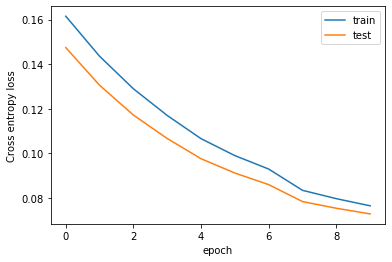

In [132]:
plt.plot(training_loss, label='train')
plt.plot(val_loss, label='test')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("Cross entropy loss")

Text(0, 0.5, 'Accuracy')

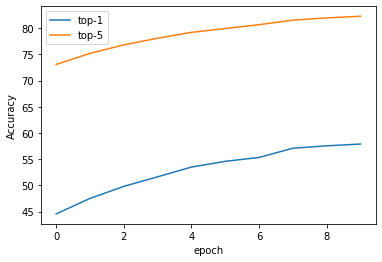

In [131]:
plt.plot(top_1_acc, label="top-1")
plt.plot(top_5_acc, label="top-5")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("Accuracy")

So, it looks like this model could continue getting better, but potentially only marginally (unless I went in and tweaked some learning parameters).

Still! In about 10 epochs, the model converged on a pretty solid accuracy!